This model will create a random forest and attempt to reduce dimensions so that we don't have to look at every protein........

In [68]:
# Partial least squares methods

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from scipy.stats import shapiro, anderson, norm

from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

import umap as U 


In [59]:
df = pd.read_excel(r'C:\Users\uqkmuroi\Desktop\Van3_results.xlsx', header = 0)

# as there are many missing columns, and some columns with missing values, we remake columns by specifying their excel equivalent
#I chose to remove any columns with no values, and columns with many missing values
columns_prot = df.iloc[:,
    list(range(183,202)) + # GB to GT
    [206] + # GY
    list(range(209, 214)) + # HB to HF
    list(range(216, 225)) + # HI to HQ
    [226] + # HS
    list(range(228, 237))] # HU to IC

# we also want the UQ strain column as it helps group the rows by experiments (since we're tryin to extract one value from each experiment)
column_strain = df['UQ Strain']

# we combine the two column sets from above
grouped = pd.concat([column_strain, columns_prot], axis=1)

# group by uq strain
grouped = grouped.groupby('UQ Strain')

# this extacts the max value (which is equivalent to the only value per experiment)
group = grouped.max()

# remove the last row as it is Nan 
# group = group.iloc[:-1]

# actually since the last row is the reference, I will change them to 1.0 
group.iloc[-1] = 1.0
print (group)
print(group.shape)

               SAH1      MET6      SAM2      SAM1       ADOI       SER3  \
UQ Strain                                                                 
VAN_011    0.476754  0.726056  8.390562  3.466260   0.826203   0.332212   
VAN_022    0.501503  0.658658  0.833097  1.069050   0.899388   2.937712   
VAN_024    0.489304  0.776491  0.848666  1.006409   1.223536   0.015000   
VAN_034    0.518499  0.560981  0.806098  0.900420   0.705531  38.200194   
VAN_035    0.563034  0.680219  0.961508  0.946449   0.747693  30.411039   
...             ...       ...       ...       ...        ...        ...   
VAN_391    4.271964  3.200832  3.767812  2.142580   1.235859   1.388874   
VAN_392    0.715643  1.176335  1.154362  1.119098   1.147058  55.464613   
VAN_393    0.731537  1.676646  1.641193  1.302600  22.974646   2.837416   
VAN_396    0.879216  0.952300  8.880651  4.468680   0.990007   1.930996   
VAN_REF7   1.000000  1.000000  1.000000  1.000000   1.000000   1.000000   

                SER1    

In [5]:
nan_count = group.isna().sum()

print (nan_count)

SAH1     0
MET6     0
SAM2     0
SAM1     0
ADOI     0
SER3     1
SER1     0
SER2     1
SHM2     0
GCV1     0
GCV2     0
GCV3     0
LPD1     0
MET13    0
FDH1     2
ADE3     0
MIS1     0
SNZ1     0
MET7     0
CBF1     1
CYS4     0
CYS3     0
HOM3     0
HOM2     0
HOM6     0
MET3     0
MET14    0
MET16    2
MET10    0
MET5     0
MET2     0
MET17    0
CHO2     2
OPI3     0
GLY1     0
FUM1     0
ICL1     0
MAE1     0
ALD6     0
ZWF1     0
PYC1     0
AGX1     0
SOL3     0
PCK1     3
dtype: int64


In [60]:
# calculate column-wise means
column_means = group.mean()

# replace NaN values
group_filled = group.fillna(column_means)

print(group_filled)
print(group_filled.shape)

               SAH1      MET6      SAM2      SAM1       ADOI       SER3  \
UQ Strain                                                                 
VAN_011    0.476754  0.726056  8.390562  3.466260   0.826203   0.332212   
VAN_022    0.501503  0.658658  0.833097  1.069050   0.899388   2.937712   
VAN_024    0.489304  0.776491  0.848666  1.006409   1.223536   0.015000   
VAN_034    0.518499  0.560981  0.806098  0.900420   0.705531  38.200194   
VAN_035    0.563034  0.680219  0.961508  0.946449   0.747693  30.411039   
...             ...       ...       ...       ...        ...        ...   
VAN_391    4.271964  3.200832  3.767812  2.142580   1.235859   1.388874   
VAN_392    0.715643  1.176335  1.154362  1.119098   1.147058  55.464613   
VAN_393    0.731537  1.676646  1.641193  1.302600  22.974646   2.837416   
VAN_396    0.879216  0.952300  8.880651  4.468680   0.990007   1.930996   
VAN_REF7   1.000000  1.000000  1.000000  1.000000   1.000000   1.000000   

                SER1    

In [61]:
#OPTIONAL use this block to log tranform data without affecting how the rest of the codw works

group_filled= np.log10(group_filled)

print(group_filled.shape)

(64, 44)


In [62]:
X_scaler= StandardScaler()
X_scaled = X_scaler.fit_transform(group_filled)

In [63]:
grouped = df.groupby('UQ Strain')
y = grouped['Vanillate DAD_G 274nm_tot'].max()
print(y)

UQ Strain
VAN_011     4952.447068
VAN_022     1164.833526
VAN_024     2909.079446
VAN_034     3843.687074
VAN_035     4110.693695
               ...     
VAN_391     6482.053633
VAN_392     3669.222194
VAN_393     3693.414898
VAN_396     2958.085578
VAN_REF7    3192.759655
Name: Vanillate DAD_G 274nm_tot, Length: 64, dtype: float64


C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_28908\66710581.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_28908\66710581.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_28908\66710581.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

Average test score (MSE): 2629676.8835351886
test scores (MSE): [2012606.9529658593, 2628450.3028152236, 2811042.564014068, 1710609.017175244, 3985675.580705548]
Average training score (MSE): 419155.6351741521
Average r2 tests: -0.2177605111575823
test r2 scores [0.1257080808231783, -0.4139696840550078, -0.04754786922176968, 0.16409571025636627, -0.9170887935906786]
Average r2 training score 0.817609743450894
MET6:0.1329
MIS1:0.1181
CBF1:0.0610
GCV3:0.0538
SOL3:0.0503
AGX1:0.0435
GCV1:0.0363
MET14:0.0348
SAH1:0.0298
MET13:0.0293
CYS4:0.0286
ZWF1:0.0268
OPI3:0.0253
SNZ1:0.0228
FDH1:0.0224
MET3:0.0205
SER2:0.0197
ALD6:0.0187
LPD1:0.0161
GCV2:0.0160
MET17:0.0150
ICL1:0.0137
MET2:0.0128
SHM2:0.0121
PCK1:0.0119
SER3:0.0118
MET16:0.0109
SAM1:0.0107
CYS3:0.0102
FUM1:0.0092
GLY1:0.0088
SER1:0.0088
MET7:0.0081
MET5:0.0075
ADOI:0.0070
CHO2:0.0061
MAE1:0.0057
HOM6:0.0041
SAM2:0.0040
MET10:0.0039
PYC1:0.0037
HOM2:0.0026
HOM3:0.0024
ADE3:0.0023
CBF1:0.0401
MET6:0.0195
MET10:0.0136
ALD6:0.0118
MET3:

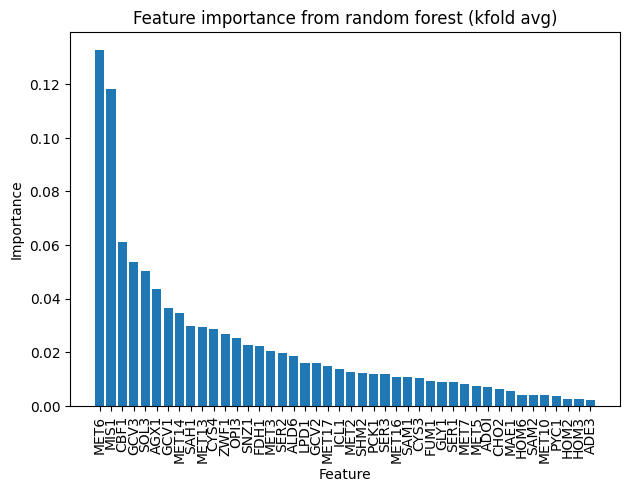

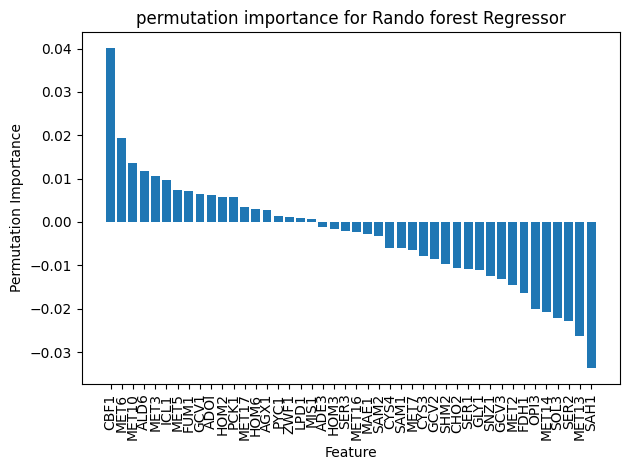

In [64]:
n_splits = 5 #the number of k-fold splits (usually 5 or 10)
n_estimators = 10 # of trees (default 100)
min_samples_split = 2 #number of samples required before split (higher prevents overfitting; default 2)
min_samples_leaf = 1 # of samples required to be leaf node (default 1)

#define the kfold
kf = KFold(n_splits = n_splits, shuffle = True, random_state=42)

#You can pick the model here: Since Decision Tree performed quite well, we can try that
model = RandomForestRegressor(n_estimators= n_estimators, min_samples_split = min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
#model = GaussianProcessRegressor()

#create list to store results
train_scores = []
test_scores = []
r2_train=[]
r2_test=[]
#setup feature importance with zeros
feature_importance = np.zeros(X_scaled.shape[1])
#create list to store permutation importance
permutation_importances =[]

#perform cross val
for train_index, test_index in kf.split(X_scaled):
    #split the data  into training and testing sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # turn off the line above and turn on below to change to the 6th time-point (instaed of all 6 Van tot/ time value)
    #y_train, y_test = y_last_scaled[train_index], y_last_scaled[test_index]

    #train the model
    model.fit(X_train, y_train)

    #make predictions on the test set
    y_pred = model.predict(X_test)

    #evaluate model
    test_score = mean_squared_error(y_test, y_pred)
    r2_test_score = r2_score(y_test, y_pred)

    #store results
    test_scores.append(test_score)
    r2_test.append(r2_test_score)

    #store training scores
    train_score = mean_squared_error(y_train, model.predict(X_train))
    train_scores.append(train_score)
    r2_train_score = r2_score(y_train, model.predict(X_train))
    r2_train.append(r2_train_score)

    
    feature_importance += model.feature_importances_

    # Calculate permutation importance on the test set for this fold
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    permutation_importances.append(result.importances_mean)  # Store the mean importance for each fold

#print results (average across all folds)
print(f"Average test score (MSE): {np.mean(test_scores)}")
print(f"test scores (MSE): {test_scores}")
print(f"Average training score (MSE): {np.mean(train_scores)}")
print(f"Average r2 tests: {np.mean(r2_test)}")
print(f"test r2 scores {r2_test}")
print(f"Average r2 training score {np.mean(r2_train)}")

feature_importance /= kf.get_n_splits()

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_features = group.columns[sorted_idx]

for i, v in enumerate(sorted_importance):
    print(f"{sorted_features[i]}:{v:.4f}")

plt.figure()
plt.bar(sorted_features, sorted_importance)
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.tight_layout()
plt.title('Feature importance from random forest (kfold avg)')

#avg permutation importance across all folds
avg_permutation_importance = np.mean(permutation_importances, axis = 0)

# sort feature importances
sorted_idx_perm = np.argsort(avg_permutation_importance)[::-1]
sorted_perm_importance = avg_permutation_importance[sorted_idx_perm]
sorted_perm_features = group.columns[sorted_idx_perm]


for i, v in enumerate(sorted_perm_importance):
    print(f"{sorted_perm_features[i]}:{v:.4f}")

plt.figure()
plt.bar(sorted_perm_features, sorted_perm_importance)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('permutation importance for Rando forest Regressor')

plt.xticks(rotation=90)
plt.tight_layout()



let's do the same thing but with decision tree, since random forest seems less effective on the training data (you can check the predictive values of each by running actual vs predicted) a few code blocks below

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_28908\1713257753.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_28908\1713257753.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_28908\1713257753.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

Average test score (MSE): 5217582.227882044
test scores (MSE): [6347934.60568059, 2668587.683831482, 9496104.203478385, 3003566.2742087822, 4571718.372210983]
Average training score (MSE): 0.0
Average r2 tests: -1.2797222658994294
test r2 scores [-1.7575915511127573, -0.43556150943347083, -2.5387666667191344, -0.467719337342424, -1.1989722648893602]
Average r2 training score 1.0
MET6:0.1497
SOL3:0.0927
MIS1:0.0719
CBF1:0.0713
GCV3:0.0535
GCV1:0.0477
MET13:0.0462
MET17:0.0424
CYS4:0.0398
SAH1:0.0361
SER3:0.0344
MET3:0.0338
SER2:0.0293
MET5:0.0256
SNZ1:0.0248
ADOI:0.0231
MET2:0.0216
HOM2:0.0204
GCV2:0.0200
MET7:0.0176
HOM6:0.0169
PCK1:0.0142
PYC1:0.0120
CHO2:0.0091
GLY1:0.0063
FDH1:0.0052
SAM2:0.0051
MET10:0.0051
ADE3:0.0045
ZWF1:0.0036
LPD1:0.0026
ALD6:0.0025
HOM3:0.0023
CYS3:0.0018
ICL1:0.0012
FUM1:0.0012
MET14:0.0012
AGX1:0.0011
OPI3:0.0008
MAE1:0.0007
SHM2:0.0003
MET16:0.0002
SER1:0.0002
SAM1:0.0000
GCV2:0.1467
HOM6:0.1180
MET6:0.0779
MET13:0.0674
MET7:0.0379
ALD6:0.0354
SAM2:0.0352


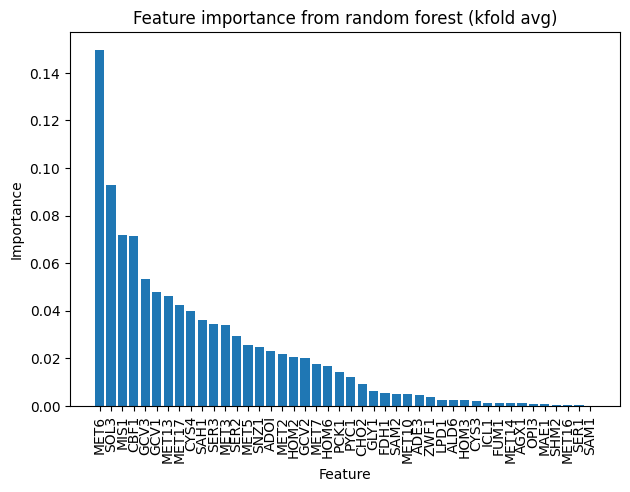

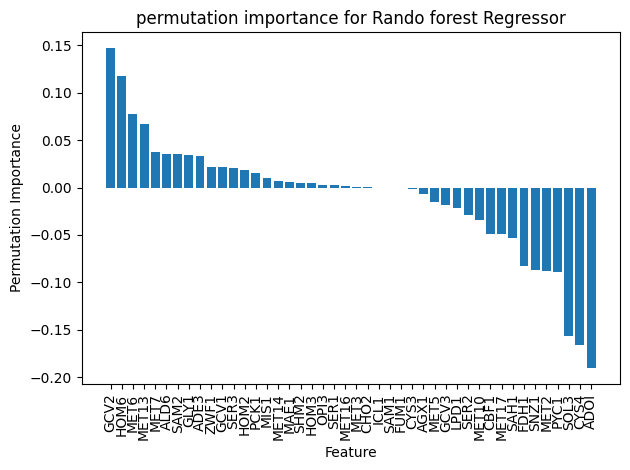

In [69]:
n_splits = 5 #the number of k-fold splits (usually 5 or 10)

min_samples_split = 2 #number of samples required before split (higher prevents overfitting; default 2)
min_samples_leaf = 1 # of samples required to be leaf node (default 1)

#define the kfold
kf = KFold(n_splits = n_splits, shuffle = True, random_state=42)

#You can pick the model here: Since Decision Tree performed quite well, we can try that
model = DecisionTreeRegressor(min_samples_split = min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
#model = GaussianProcessRegressor()

#create list to store results
train_scores = []
test_scores = []
r2_train=[]
r2_test=[]
#setup feature importance with zeros
feature_importance = np.zeros(X_scaled.shape[1])
#create list to store permutation importance
permutation_importances =[]

#perform cross val
for train_index, test_index in kf.split(X_scaled):
    #split the data  into training and testing sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # turn off the line above and turn on below to change to the 6th time-point (instaed of all 6 Van tot/ time value)
    #y_train, y_test = y_last_scaled[train_index], y_last_scaled[test_index]

    #train the model
    model.fit(X_train, y_train)

    #make predictions on the test set
    y_pred = model.predict(X_test)

    #evaluate model
    test_score = mean_squared_error(y_test, y_pred)
    r2_test_score = r2_score(y_test, y_pred)

    #store results
    test_scores.append(test_score)
    r2_test.append(r2_test_score)

    #store training scores
    train_score = mean_squared_error(y_train, model.predict(X_train))
    train_scores.append(train_score)
    r2_train_score = r2_score(y_train, model.predict(X_train))
    r2_train.append(r2_train_score)

    
    feature_importance += model.feature_importances_

    # Calculate permutation importance on the test set for this fold
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    permutation_importances.append(result.importances_mean)  # Store the mean importance for each fold

#print results (average across all folds)
print(f"Average test score (MSE): {np.mean(test_scores)}")
print(f"test scores (MSE): {test_scores}")
print(f"Average training score (MSE): {np.mean(train_scores)}")
print(f"Average r2 tests: {np.mean(r2_test)}")
print(f"test r2 scores {r2_test}")
print(f"Average r2 training score {np.mean(r2_train)}")

feature_importance /= kf.get_n_splits()

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_idx]
sorted_features = group.columns[sorted_idx]

for i, v in enumerate(sorted_importance):
    print(f"{sorted_features[i]}:{v:.4f}")

plt.figure()
plt.bar(sorted_features, sorted_importance)
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.tight_layout()
plt.title('Feature importance from random forest (kfold avg)')

#avg permutation importance across all folds
avg_permutation_importance = np.mean(permutation_importances, axis = 0)

# sort feature importances
sorted_idx_perm = np.argsort(avg_permutation_importance)[::-1]
sorted_perm_importance = avg_permutation_importance[sorted_idx_perm]
sorted_perm_features = group.columns[sorted_idx_perm]


for i, v in enumerate(sorted_perm_importance):
    print(f"{sorted_perm_features[i]}:{v:.4f}")

plt.figure()
plt.bar(sorted_perm_features, sorted_perm_importance)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('permutation importance for Rando forest Regressor')

plt.xticks(rotation=90)
plt.tight_layout()



The below can be tested to see how the model converged on the data by comparing actual and predicted values.

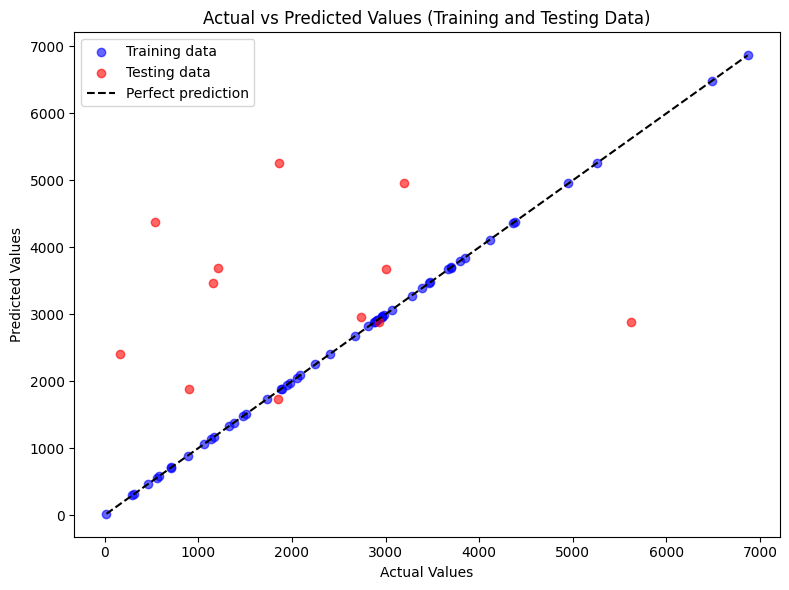

In [70]:
# After fitting the model, get predictions on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Plot training data (True values vs Predicted values)
plt.scatter(y_train, y_train_pred, color='blue', label='Training data', alpha=0.6)

# Plot testing data (True values vs Predicted values)
plt.scatter(y_test, y_test_pred, color='red', label='Testing data', alpha=0.6)

# Plot a 45-degree line (ideal case where actual = predicted)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         color='black', linestyle='--', label='Perfect prediction')

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Training and Testing Data)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Since the decision tree fits the training data quite well (random forest didn't perform quite as well). However, some hyperparamter tuning below are available

But let's focus on picking the highest importance features and see if the model works better by only looking at a few features.

[0.14972092 0.09272781 0.07192752 0.07133267 0.05349748]
Index(['MET6', 'SOL3', 'MIS1', 'CBF1', 'GCV3'], dtype='object')
Mean Squared Error(GPR): 9235390.0620
R² Score: -3.3619


c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


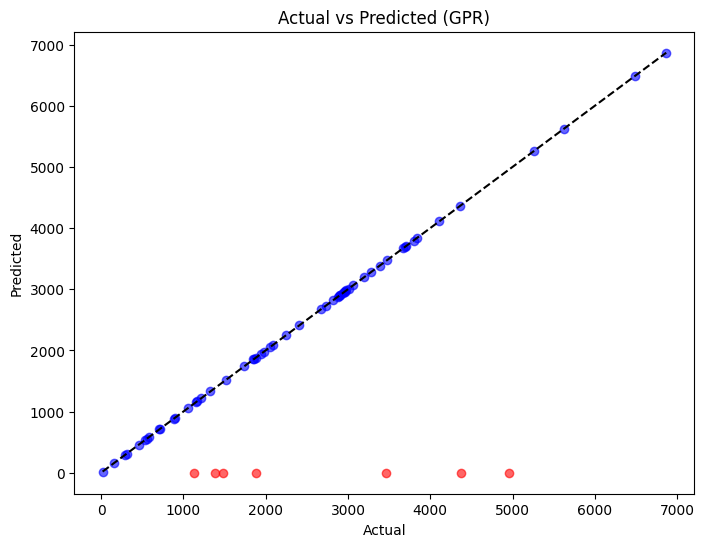

Mean Squared Error(dt): 3316932.8488
R² Score: -0.5666


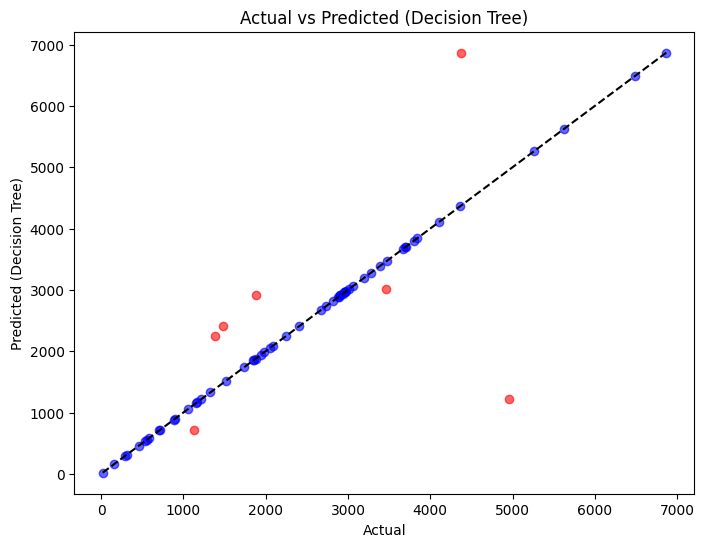

In [86]:
from sklearn.model_selection import train_test_split
n_top_features=5

# Get the sorted indices for the top n important features

top_features_idx = sorted_importance[:n_top_features]
top_sorted_features = sorted_features[:n_top_features]

print(top_features_idx)
print(top_sorted_features)

# Select only the top n important features from X
X_selected = group_filled.loc[:, top_sorted_features]  # Assuming X_scaled is your input features

X_selected_scaler = StandardScaler()
X_selected_scaled = X_selected_scaler.fit_transform(X_selected)

# Split the data into training and test sets (you may already have this step)
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.1, random_state=42)

# Initialize the GaussianProcessRegressor with a kernel (you can adjust the kernel as needed)
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Fit the Gaussian Process Regressor on the selected features
gpr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = gpr_model.predict(X_train)
y_test_pred = gpr_model.predict(X_test)

# Evaluate the model (for example, using R² or MSE)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error(GPR): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs Predicted values
plt.figure(figsize=(8, 6))
'''
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

'''
# Plot training data (True values vs Predicted values)
plt.scatter(y_train, y_train_pred, color='blue', label='Training data', alpha=0.6)

# Plot testing data (True values vs Predicted values)
plt.scatter(y_test, y_test_pred, color='red', label='Testing data', alpha=0.6)

# Plot a 45-degree line (ideal case where actual = predicted)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (GPR)')
plt.show()

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error(dt): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs Decision Tree predictions
plt.figure(figsize=(8, 6))
'''
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
'''

# Plot training data (True values vs Predicted values)
plt.scatter(y_train, y_train_pred, color='blue', label='Training data', alpha=0.6)

# Plot testing data (True values vs Predicted values)
plt.scatter(y_test, y_test_pred, color='red', label='Testing data', alpha=0.6)

# Plot a 45-degree line (ideal case where actual = predicted)
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         color='black', linestyle='--', label='Perfect prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted (Decision Tree)')
plt.title('Actual vs Predicted (Decision Tree)')
plt.show()

In [57]:
from sklearn.model_selection import GridSearchCV


# Define the model
model = RandomForestRegressor(random_state=42)

# Set the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_scaled, y)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score (MSE):", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (MSE): -2161219.111295183


In [72]:
from sklearn.model_selection import GridSearchCV


# Define the model
model = DecisionTreeRegressor(random_state=42)

# Set the hyperparameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_scaled, y)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score (MSE):", grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Score (MSE): -2776827.557950155


In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the model
model = RandomForestRegressor(random_state=42)

# Set the hyperparameter distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [ 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, verbose=2)

# Fit RandomizedSearchCV
random_search.fit(X_scaled, y)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score (MSE):", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
155 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
93 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\uqkmuroi\.virtualenvs\ML_for_pre

Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 440}
Best Score (MSE): -2028881.4256618053
